In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
pd.set_option('display.max_rows', 200)

def postgres_conn(schema):
    import psycopg2
    
    list_cori_schema = ['coririsi_layer', 'coririsi_source', 'coririsi_public', 'coririsi_geo', 'coririsi_analysis', 'coririsi_temp']
    
    if schema in list_cori_schema:
        if schema == 'coririsi_layer':
            conn_opition = '-c search_path=sch_layer'
        elif schema == 'coririsi_source':
              conn_opition = '-c search_path=sch_source'
        elif schema == 'coririsi_public':
              conn_opition = '-c search_path=public'
        elif schema == 'coririsi_analysis':
              conn_opition = '-c search_path=sch_analysis'
        elif schema == 'coririsi_temp':
              conn_opition = '-c search_path=sch_temp'
        elif schema == 'coririsi_geo':
              conn_opition = '-c search_path=sch_census_tiger'
    else:
        raise KeyError("Unrecognized postgres schema. Please choose from " + str(list_cori_schema).strip('[]'))
        

    try:
        conn = psycopg2.connect(dbname='data',
                                user='risi_fanniemae',
                                host='cori-risi.c6zaibvi9wyg.us-east-1.rds.amazonaws.com', 
                                password='85h!M1az%6sR#s2Z2$5DueCJ4PuJbI',
                                options =  conn_opition)
    except:
        print("I am unable to connect to the database")

    return conn




In [2]:
def sir_model(y, x, beta, gamma):
    dsdt = -beta * y[0] * y[1] / N
    drdt = gamma * y[1]
    didt = beta * y[0] * y[1] / N - gamma * y[1]
    return dsdt, didt, drdt

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]



In [10]:
conn = postgres_conn("coririsi_layer")

covid_select_Query = "select * from covid_19_county_long"
x_covid_time = pd.read_sql_query(covid_select_Query, conn)

attr_select_Query = "select geoid, total_population_2018 from attr_county_full"
x_pop = pd.read_sql_query(attr_select_Query, conn)

x_covid_time_pop = x_covid_time.merge(x_pop,
                                left_on='geoid', 
                                right_on='geoid', 
                                how='left')
x_covid_time_pop_test = x_covid_time_pop.loc[x_covid_time_pop['namelsad'] == 'Los Angeles County']
x_covid_time_pop_test = x_covid_time_pop_test.drop_duplicates(subset = 'Last_Update')
x_covid_time_pop_test['day_count'] = list(range(1,len(x_covid_time_pop_test)+1))



In [4]:
x_covid_time_pop_test

,namelsad,st_stusps,us_region,us_subregion,wikipedia,geoid,geoid_st,countyfp,countyns,affgeoid,...,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,latest_update,geometry,total_population_2018,day_count
765,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,536,7,0,0,"Los Angeles, California, US",2020-03-23,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,1
766,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,662,11,0,0,"Los Angeles, California, US",2020-03-24,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,2
767,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,812,13,0,0,"Los Angeles, California, US",2020-03-25,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,3
768,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,1229,21,0,0,"Los Angeles, California, US",2020-03-26,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,4
769,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,1465,26,0,0,"Los Angeles, California, US",2020-03-27,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,5
770,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,1465,26,0,0,"Los Angeles, California, US",2020-03-28,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,6
771,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,1829,32,0,0,"Los Angeles, California, US",2020-03-29,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,7
772,Los Angeles County,CA,West Coast,none,https://en.wikipedia.org/wiki/Los Angeles_Coun...,06037,06,037,00277283,0500000US06037,...,-118.228241,2474,44,0,0,"Los Angeles, California, US",2020-03-30,0101000020AD100000E6726A49638E5DC07123F41A0E29...,10100000.0,8


In [12]:
s_data = [x_covid_time_pop_test.iloc[0]["total_population_2018"] - i for i in x_covid_time_pop_test.Confirmed.values]
i_data = [i for i in x_covid_time_pop_test.Confirmed.values - x_covid_time_pop_test.Deaths.values - x_covid_time_pop_test.Recovered.values]
r_data = [i for i in x_covid_time_pop_test.Deaths.values + x_covid_time_pop_test.Recovered.values]
t_data = x_covid_time_pop_test.day_count
confirm_data = [i for i in x_covid_time_pop_test.Confirmed.values]

y_data = [s_data, i_data, r_data]

N = x_covid_time_pop_test.iloc[0]["total_population_2018"]
inf0 = i_data[0]
sus0 = s_data[0]
rec0 = r_data[0]

popt, pcov = optimize.curve_fit(fit_odeint, t_data, i_data)
fitted = fit_odeint(t_data, *popt)
fitted_more = fit_odeint(list(range(100)), *popt)


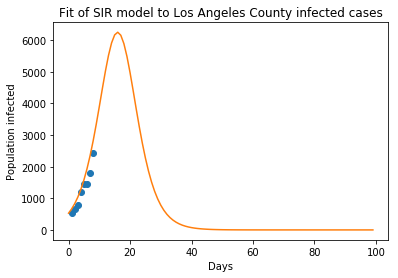

Optimal parameters: beta = -6.72285386877985  and gamma =  -6.950125067382418


In [13]:
plt.plot(t_data, i_data, 'o')

plt.plot(list(range(100)), fitted_more)
plt.title("Fit of SIR model to "+ x_covid_time_pop_test.iloc[0]["namelsad"] + " infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
